# Introdução

# I. Sobre o Negócio

## Florestas Plantadas no Brasil

## *Contexto*

As florestas plantadas constituem recursos muito importantes para a vida humana [<sup>1</sup>](#ref1). Suas implicações vão desde a preservação do meio ambiente até estratégias econômicas para negócios internacionais.

Em vez de desmatar florestas naturais para extrair recursos necessários, podemos realizar o plantio de novas florestas (daí o nome florestas plantadas). Essa prática possibilita a preservação da biodiversidade e funciona como uma solução mais sustentável frente os desafios da extração de recursos do mundo atual. São benefícios econômicos e ecológicos decorrentes das florestas plantadas [<sup>1</sup>](#ref1):

1. Regulação do fluxo hídrico;
2. Controle do clima;
3. Formação de estoques de carbono;
4. Conservação do solo;
5. Dispersão de sementes;
6. Ciclagem de nutrientes;
7. Formação de corredores ecológicos;
8. Atividades culturais, científicas, recreativas e educacionais.

Nosso planeta possui 4,06 bilhões de hectares de florestas. Mais da metade das florestas está compreendida em cinco países [<sup>2</sup>](#ref2): 

1. Rússia (815 milhões de hectares). 
2. **Brasil (497 milhões)**. 
3. Canadá (347 milhões).
4. Estados Unidos (310 milhões).
5. China (220 milhões).

Apenas 7% dessas florestas são plantadas. Dessas florestas plantadas, **a maioria está no Brasil** [<sup>2</sup>](#ref2).

A história das florestas plantadas no Brasil se inicia em 1903 com a plantação de mudas de Eucalipto. Em 1947 inciou-se o plantio de Pinus, útil para a produção de celulose e papel [<sup>3</sup>](#ref3). Os principais produtos florestais advindos de florestas plantadas alimentam diversas indústrias. Seguem alguns exemplos [<sup>4</sup>](#ref4): painéis, celulose, papel, madeira serrada, carvão vegetal e energia.

Os principais dados que possuímos (abertos ao público) advêm de duas fontes:

1. Indústria Brasileira de Árvores (**Ibá** - tratado neste projeto como **IBA**);
2. Instituto Brasileiro de Geografia e Estatística (**IBGE**).

No sítio do Sistema Nacional de Informações Florestais (**SNIF**) [<sup>3</sup>](#ref3) temos à nossa disposição os dados pertinentes às florestas plantadas no Brasil no período de **2006 a 2016 (IBA)** e de **2013 a 2019 (IBGE)**. Ambos os conjuntos de dados contêm informações de plantios realizados (em hectares) em todas as regiões do Brasil. Vale destacar que há um ótimo painel interativo neste mesmo sítio que permite navegar de forma bastante intuitiva pelos dados.

<img align="left" src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Eucalyptus_tree.jpg/200px-Eucalyptus_tree.jpg" alt="Exemplo de Eucalipto" title="Exemplo de Eucalipto" hspace="5" width="300"/>

<img align="center" src="https://upload.wikimedia.org/wikipedia/commons/9/97/Slash_pine.jpg" alt="Exemplo de Pinus" title="Exemplo de Pinus" hspace="5" width="300"/>

# II. Questão de Negócio

Dado o contexto apresentado, podemos fazer a seguinte pergunta sobre as florestas plantadas no Brasil:

**Qual será o plantio estimado, em hectares, para os próximos anos?**

# III. Coleta e Natureza dos Dados

Coletou-se os dados diretamente da página dedicada às florestas plantadas no Brasil, do SNIF [<sup>3</sup>](#ref3). Tratam-se de **dois arquivos no formato CSV**, baixados e utilizados daqui em diante.

**Observação**: optou-se por combinar os arquivos de acordo com a coluna Ano.

Consolidou-se os dados dos anos de 2006 a 2016, do IBA, com os de 2017 a 2019, do IBGE.
Ainda assim, o código deste projeto está preparado para realizar o estudo de cada base (IBA, IBGE, ou ambos), se desejado.

# Predição de Florestas Plantadas no Brasil

# 1. Importação das Bibliotecas

In [1292]:
import numpy as np, pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# 2. Preparação dos Dados

In [1293]:
# read and concatenate data
data_IBA = pd.read_csv('FP_IBA.csv', delimiter=';')
data_IBGE = pd.read_csv('FP_IBGE.csv', delimiter=';')

# prepare and get relevant columns - IBA
data_IBA['Ano'] = data_IBA['Ano'].str.slice(start=6)
data_IBA.rename(index=str, columns={'Área (ha)': 'Área'}, inplace=True)
data_IBA = data_IBA[['Ano', 'Cultura', 'Estado',  'Área']]
data_IBA['Ano'] = data_IBA['Ano'].astype(int)
data_IBA = data_IBA.fillna(0)

# prepare and get relevant columns - IBGE
data_IBGE.rename(index=str, columns={'Espécie florestal': 'Cultura', 'Nome UF': 'Estado', 'Área (ha)': 'Área'}, inplace=True)
data_IBGE = data_IBGE[['Ano PEVS', 'Cultura', 'Estado', 'Área']]
data_IBGE.rename(index=str, columns={'Ano PEVS': 'Ano'}, inplace=True)
data_IBGE = data_IBGE.fillna(0)

# prepare and get relevant columns - IBA and IBGE

# get IBGE data and concat to IBA data
data_IBGE = data_IBGE.loc[data_IBGE['Ano'] > 2016]

frames_to_concat = [data_IBA, data_IBGE]
data_IBA_and_IBGE = pd.concat(frames_to_concat)

# convert "Área"to millions
data_IBA['Área'] = data_IBA['Área'] / 10
data_IBGE['Área'] = data_IBGE['Área'] / 10
data_IBA_and_IBGE['Área'] = data_IBA_and_IBGE['Área'] / 10

data_IBA_and_IBGE.tail(7)

#data_IBA.describe().transpose()
#data_IBA.tail()
#data_IBGE.head()
#data_IBGE.tail()
#data_IBGE.describe().transpose()

,Ano,Cultura,Estado,Área
77126,2019,Pinus,Paraná,3537.8
77127,2019,Pinus,Rio Grande do Sul,3675.0
77128,2019,Pinus,Rio Grande do Sul,3675.0
77129,2019,Pinus,Paraná,4076.8
77130,2019,Pinus,Santa Catarina,4500.0
77131,2019,Pinus,Rio Grande do Sul,5600.0
77132,2019,Pinus,Paraná,6945.0


# 3. Análise Exploratória de Dados (AED)

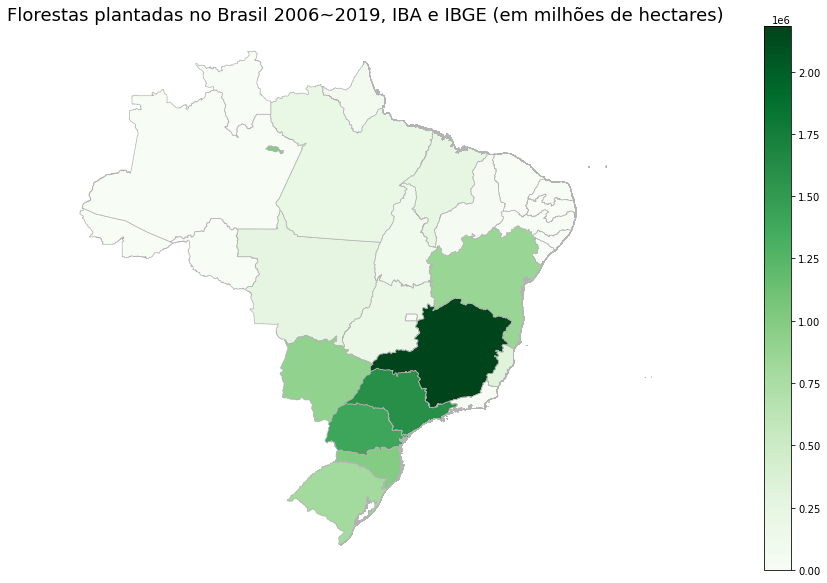

In [1294]:
getBrazilMap(data_IBA_and_IBGE, 'IBA e IBGE')

Florestas plantadas no Brasil: Área, em milhões de hectares, por Ano (IBA e IBGE)
                   Área
Ano                    
2006           574883.2
2007           595282.3
2008           628838.9
2009           645364.4
2010           711969.9
2011           718088.7
2012           738807.7
2013           760097.5
2014           773617.1
2015           780104.7
2016           784747.8
2017           976378.3
2018           986495.0
2019           998309.5
Grand Total  10672985.0
---


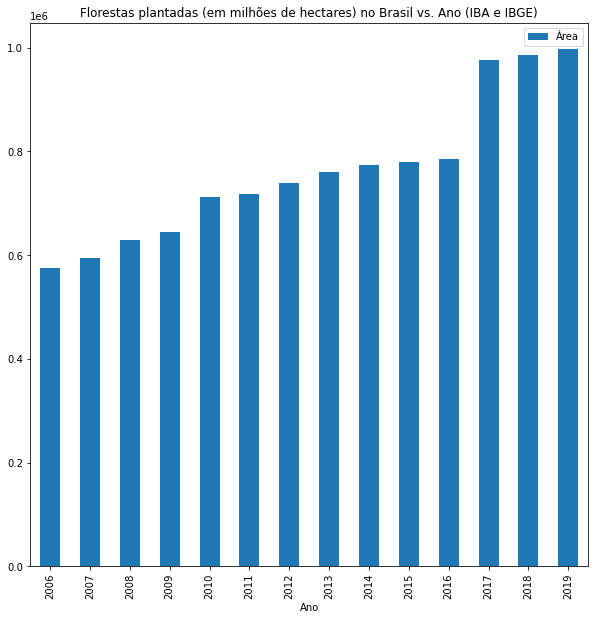

In [1295]:
summarizeDataByYear(data_IBA_and_IBGE, 'IBA e IBGE')

Florestas plantadas no Brasil: Área, em milhões de hectares, por Cultura (IBA e IBGE)
                       Área
Cultura                    
Eucalipto         7723241.6
Outras culturas    379753.9
Outras espécies    113672.9
Pinus             2456316.6
Grand Total      10672985.0
---


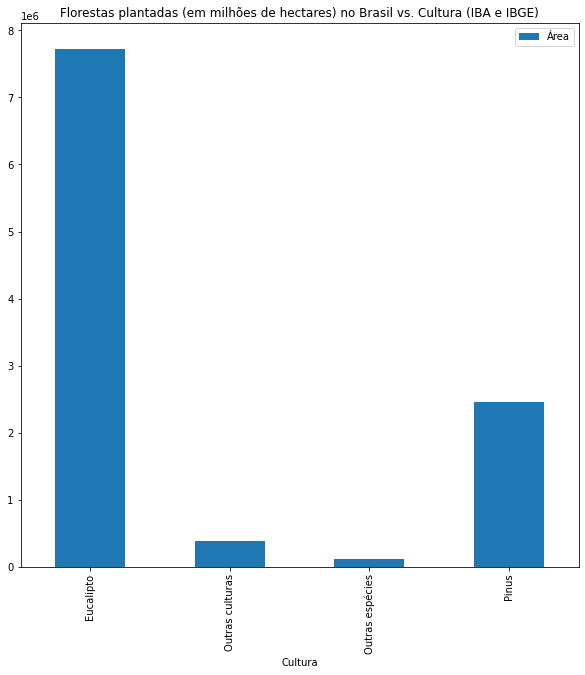

In [1296]:
summarizeDataByCulture(data_IBA_and_IBGE, 'IBA e IBGE')

Florestas plantadas no Brasil: Área, em milhões de hectares, por Estado (IBA e IBGE)
                           Área
Estado                         
Rio Grande do Norte        10.2
Ceará                     178.8
Pernambuco               1026.7
Distrito Federal         1254.0
Sergipe                  1581.3
Paraíba                  1795.9
Alagoas                  6140.8
Roraima                  7201.5
Rondônia                 8007.2
Rio de Janeiro           9944.1
Outros                  22493.1
Piauí                   31034.6
Amapá                   83449.1
Tocantins              124470.1
Goiás                  193824.9
Pará                   215933.1
Maranhão               254991.9
Mato Grosso            257746.5
Espírito Santo         321769.1
Não informado          379753.9
Rio Grande do Sul      802740.8
Bahia                  864950.7
Mato Grosso do Sul     905274.5
Santa Catarina         994318.7
Paraná                1399843.0
São Paulo             1601188.9
Minas Gerais       

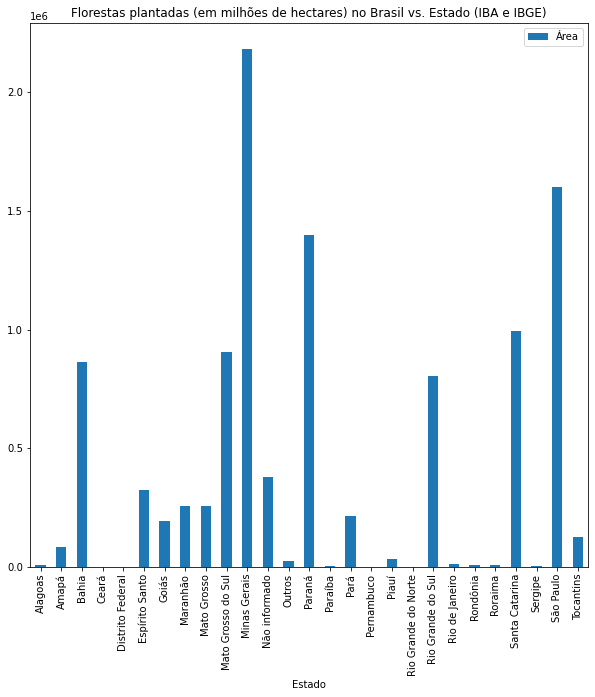

In [1297]:
summarizeDataByState(data_IBA_and_IBGE, 'IBA e IBGE')

Florestas plantadas no Brasil: Área, em milhões de hectares, por Cultura e Ano (IBA e IBGE)
                               Área
(Eucalipto, 2006)          386254.6
(Eucalipto, 2007)          407816.7
(Eucalipto, 2008)          445606.9
(Eucalipto, 2009)          465892.4
(Eucalipto, 2010)          490095.0
(Eucalipto, 2011)          504971.2
(Eucalipto, 2012)          530416.3
(Eucalipto, 2013)          547317.6
(Eucalipto, 2014)          555865.3
(Eucalipto, 2015)          563060.7
(Eucalipto, 2016)          567378.4
(Eucalipto, 2017)          743275.3
(Eucalipto, 2018)          753672.8
(Eucalipto, 2019)          761618.4
(Outras culturas, 2010)     46239.0
(Outras culturas, 2011)     48928.2
(Outras culturas, 2012)     52113.1
(Outras culturas, 2013)     55765.3
(Outras culturas, 2014)     58852.1
(Outras culturas, 2015)     58920.1
(Outras culturas, 2016)     58936.1
(Outras espécies, 2017)     37997.1
(Outras espécies, 2018)     36945.1
(Outras espécies, 2019)     38730.7
(Pinus, 

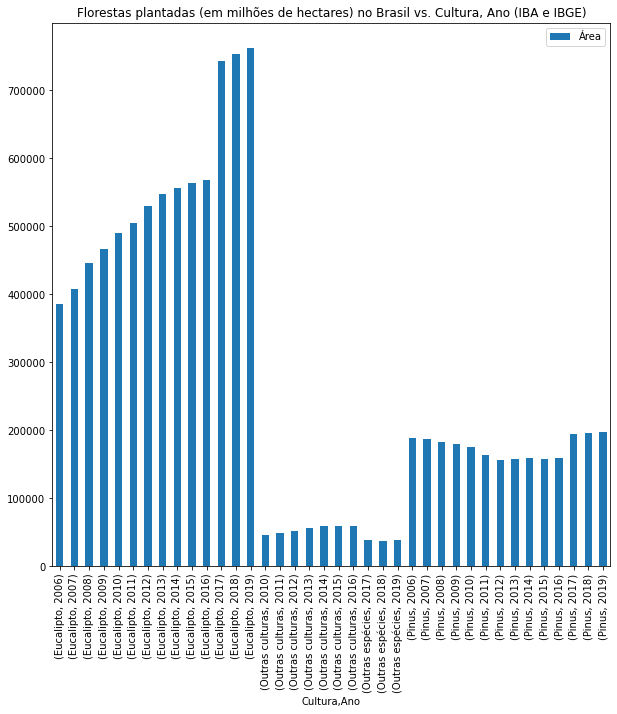

In [1298]:
summarizeDataByCultureAndYear(data_IBA_and_IBGE, 'IBA e IBGE')

Análise da série temporal sobre as florestas plantadas no Brasil (IBA e IBGE):


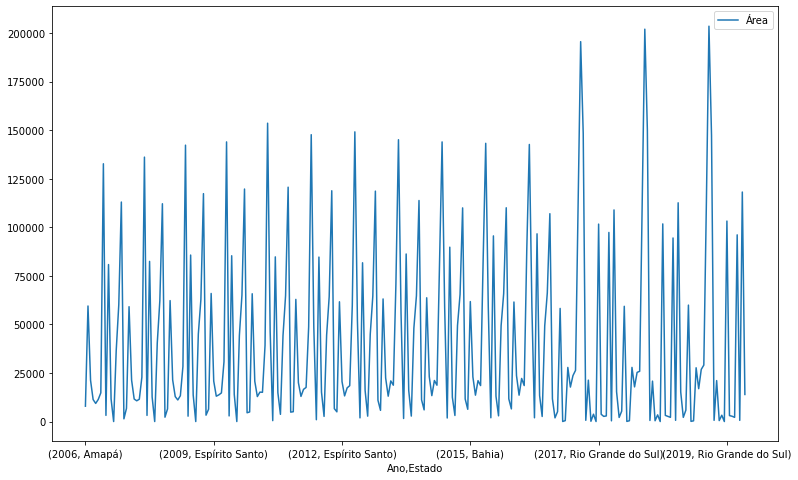

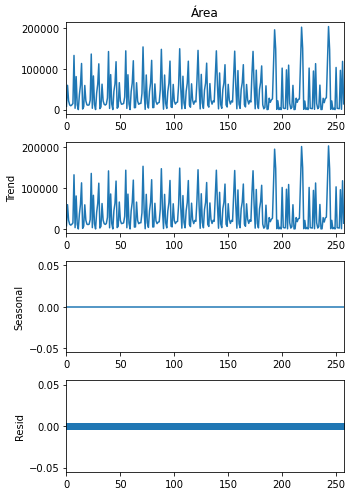

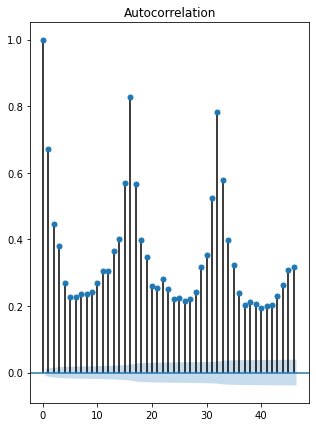

In [1299]:
getTimeSeries(data_IBA_and_IBGE, 'IBA e IBGE')

Conforme AED realizada, podemos perceber que:

1. Segundo o IBA, em 10 anos (de 2006 a 2016), houve a plantação de mais de 77 milhões de hectares de florestas no Brasil.
2. Segundo o IBGE, em 6 anos (de 2013 a 2019), houve a plantação de mais de 67 milhões de hectares de florestas no Brasil.
3. Estados como Minas Gerais, São Paulo, Paraná e Santa Catarina (regiões Sudeste e Sul do Brasil) estão dentre os que mais fazem plantação de florestas.
4. Em geral, há mais plantio conforme avançamos no tempo (vide primeiro gráfico de barras e decomposição da série temporal). Esta tendência de crescimento implica que a série estudada não é estacionária.
5. Segundo o gráfico de autocorrelação, podemos perceber mais do que 2 pontos (ou > 5%) de janela fora do intervalo de confiança para correlação igual a zero (sombreado em azul), significando alta correlação entre os valores das áreas plantadas.
6. Ainda sobre o gráfico de autocorrelação, pode-se perceber até 2 pontos (como nas janelas 1 e 2) com correlação positiva maior do que 0,4, ou seja, um bom palpite é analisar a série utilizando um deslocamento de 2 lags.
7. Eucalipto é a cultura mais plantada: percebe-se a importância desta cultura desde que se começou a plantar florestas no Brasil, em 1903.
8. A plantação de Pinus começou a cair em 2007, mas voltou a crescer em 2012: percebe-se forte demanda da indústria e/ou conscientização das partes envolvidas por plantações desta cultura.

# 4. Modelagem - ARIMA

Predição para os próximos anos.

In [1300]:
# seed for reproducibility
np.random.seed(42021)

Modelagem utilizando ARIMA (IBA e IBGE) - Área em Milhões de Hectares
---
Predição = 785378.13, esperado = 976378.30
Predição = 984634.42, esperado = 986495.00
Predição = 1000607.99, esperado = 998309.50
---
RMSE do teste: 110287.22
---
Predição para 2020 (IBA e IBGE): 1001925.95
Predição para 2021 (IBA e IBGE): 1002989.50
Predição para 2022 (IBA e IBGE): 1003128.50


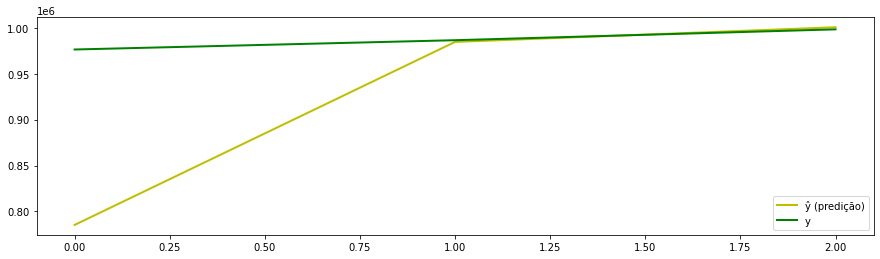

In [1301]:
doARIMA(data_IBA_and_IBGE, 'IBA e IBGE', 2020, 2022)

# 5. Modelagem - Regressão Linear

Predição para o próximo ano.

Modelagem utilizando Regressão Linear (IBA e IBGE) - Área em Milhões de Hectares:
---
Validação cruzada, -RMSE:
Fold 0 = -65652.08
Fold 1 = -3050.66
Fold 2 = -9460.54
---
Predição = 794284.39, esperado = 976378.30
Predição = 962076.46, esperado = 986495.00
Predição = 970934.67, esperado = 998309.50
---
Predição para 2020 (IBA e IBGE): 957310.00


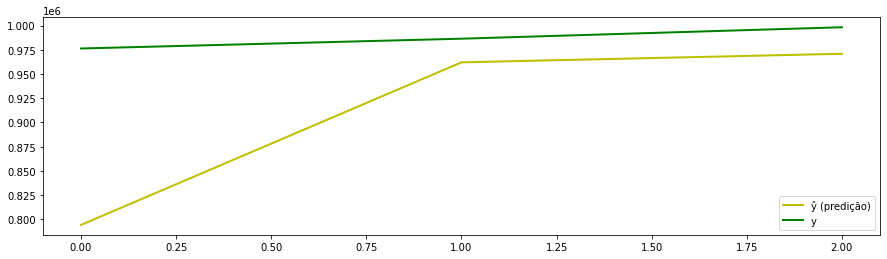

In [1302]:
doLinearRegression(data_IBA_and_IBGE, 'IBA e IBGE')

# 6. Conclusões

As florestas plantadas no Brasil são importantes e necessárias para o seu desenvolvimento. Devido à alta demanda e maior conscientização dos cidadãos, observamos um aumento de áreas de florestas plantadas a cada ano. Diversas culturas (espécies florestais) vêm sendo plantadas e utilizadas como fonte de produção em diversos setores da sociedade. Assim sendo, decorre:

1. A predição para os próximos anos é de um crescimento aproximado de 0,1% ao ano, atingindo-se, em 2020, a marca de 100 milhões de hectares de florestas plantadas no Brasil (desde 2006).

2. O modelo de regressão linear não obteve um crescimento para 2020 devido à dificuldade de se conceber uma janela de tempo, ou lags, condizente com um erro satisfatoriamente pequeno durante a fase de treinamento.

3. Vide tópico anterior, observou-se que o modelo ARIMA, além de possuir menor erro, nos concedeu as principais conclusões aqui discutidas. Sendo assim, podemos afirmar um crescimento de áreas de florestas plantadas, principalmente de Eucalipto e Pinus, nas regiões Sul e Sudeste do Brasil, lideradas por: Minas Gerais, São Paulo e Paraná.

**Predições para os próximos anos:**

2020: 100.192.595 hectares.

2021: 100.298.950 hectares.

2022: 100.312.850 hectares.

# 7. Referências

<span id="ref1"> 1. [Florestas Plantadas e as suas Principais Contribuições!](https://agropos.com.br/florestas-plantadas/) </span>

<span id="ref2"> 2. [Retrato atual das florestas no mundo](https://www.agroplanning.com.br/2020/07/28/retrato-atual-das-florestas-no-mundo/) </span>

<span id="ref3"> 3. [Florestas Plantadas - Sistema Nacional de Informações Florestais](https://snif.florestal.gov.br/pt-br/florestas-plantadas) </span>

<span id="ref4"> 4. [Plano Nacional de Desenvolvimento de Florestas Plantadas](https://www.gov.br/agricultura/pt-br/assuntos/politica-agricola/outras-publicacoes/plano-nacional-de-desenvolvimento-de-florestas-plantadas.pdf) </span>

# Métodos utilizados neste projeto

In [1303]:
# plot map of Brazil planted forests
# @data: data_IBA or data_IBGE or data_IBA_and_IBGE
# @data_name: 'IBA' or 'IBGE' or 'IBA e IBGE'    
def getBrazilMap(data, data_name):
    if (data_name == 'IBA'):
        years_to_study = '2006~2016'
    elif (data_name == 'IBGE'):
        years_to_study = '2013~2019'
    else:
        years_to_study = '2006~2019'
            
    data_per_state = data.groupby(by=['Estado']).sum()
    data_per_state = data_per_state.reset_index(level=0)
    
    columns_Brazil = ['NAME_1']
    df_Brazil_map = pd.read_csv('BRA_adm1.csv', usecols=columns_Brazil)
    df_Brazil_map.columns = ['Estado']
    
    df_merged = pd.merge(df_Brazil_map, data_per_state, how='outer', on=['Estado'])
    df_merged = df_merged.fillna(0)
    
    map_source = 'BRA_adm1.shp'

    map_df = gpd.read_file(map_source)

    map_merged = map_df.join(df_merged)
    map_merged = map_merged.dropna()
    df_merged = df_merged[['Estado', 'Área']]
    
    vmin = 0
    vmax = max(data_per_state['Área'])

    fig, ax = plt.subplots(1, figsize=(30, 10))
    
    graph_title = 'Florestas plantadas no Brasil %s, %s (em milhões de hectares)' % (years_to_study, data_name)

    ax.set_title(graph_title, fontdict={'fontsize': '18', 'fontweight' : '3'})
    ax.axis('off')
    sm = plt.cm.ScalarMappable(cmap='Greens',norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm)
    
    # "Não informado" and "Outros" are ignored
    map_merged.plot(column='Área', cmap='Greens', linewidth=0.7, ax=ax, edgecolor='0.7')

In [1304]:
# show planted forests data, by year
# @data: data_IBA or data_IBGE or data_IBA_and_IBGE
# @data_name: 'IBA' or 'IBGE' or 'IBA e IBGE' 
def summarizeDataByYear(data, data_name):
    print('Florestas plantadas no Brasil: Área, em milhões de hectares, por Ano (%s)' % data_name)
    data_by_year = data.groupby(by=['Ano']).sum()
    data_by_year.loc['Grand Total'] = data_by_year.sum()
    print(data_by_year)
    
    # plot data
    print('---')
    graph_title = title='Florestas plantadas (em milhões de hectares) no Brasil vs. Ano (%s)' % data_name
    data.groupby(by=['Ano']).sum().plot.bar(title=graph_title, legend='best', figsize=(10,10))

In [1305]:
# show planted forests data, by culture
# @data: data_IBA or data_IBGE or data_IBA_and_IBGE
# @data_name: 'IBA' or 'IBGE' or 'IBA e IBGE' 
def summarizeDataByCulture(data, data_name):
    print('Florestas plantadas no Brasil: Área, em milhões de hectares, por Cultura (%s)' % data_name)
    data_culture = data[['Área', 'Cultura']]
    data_by_culture = data_culture.groupby(by=['Cultura']).sum()
    data_by_culture.loc['Grand Total'] = data_by_culture.sum()
    print(data_by_culture)
    
    # plot data
    print('---')
    graph_title = title='Florestas plantadas (em milhões de hectares) no Brasil vs. Cultura (%s)' % data_name
    data_culture.groupby(by=['Cultura']).sum().plot.bar(title=graph_title, legend='best', figsize=(10,10))

In [1306]:
# show planted forests data, by state
# @data: data_IBA or data_IBGE or data_IBA_and_IBGE
# @data_name: 'IBA' or 'IBGE' or 'IBA e IBGE' 
def summarizeDataByState(data, data_name):
    print('Florestas plantadas no Brasil: Área, em milhões de hectares, por Estado (%s)' % data_name)
    data_state = data[['Estado', 'Área']]
    data_by_state = data_state.groupby(by=['Estado']).sum()
    data_by_state.loc['Grand Total'] = data_by_state.sum()
    print(data_by_state.sort_values('Área'))
    
    # plot data
    print('---')
    graph_title = title='Florestas plantadas (em milhões de hectares) no Brasil vs. Estado (%s)' % data_name
    data_state.groupby(by=['Estado']).sum().plot.bar(title=graph_title, legend='best', figsize=(10,10))

In [1307]:
# show planted forests data, by culture and year
# @data: data_IBA or data_IBGE or data_IBA_and_IBGE
# @data_name: 'IBA' or 'IBGE' or 'IBA e IBGE' 
def summarizeDataByCultureAndYear(data, data_name):
    print('Florestas plantadas no Brasil: Área, em milhões de hectares, por Cultura e Ano (%s)' % data_name)
    data_culture_year = data[['Área', 'Cultura', 'Ano']]
    data_by_culture_and_year = data_culture_year.groupby(by=['Cultura', 'Ano']).sum()
    data_by_culture_and_year.loc['Grand Total'] = data_by_culture_and_year.sum()
    print(data_by_culture_and_year)
    
    # plot data
    print('---')
    graph_title = title='Florestas plantadas (em milhões de hectares) no Brasil vs. Cultura, Ano (%s)' % data_name
    data_culture_year.groupby(by=['Cultura', 'Ano']).sum().plot.bar(title=graph_title, legend=True, figsize=(10,10))

In [1308]:
# Perform time series analysis
# @data: data_IBA or data_IBGE or data_IBA_and_IBGE 
# @data_name: 'IBA' or 'IBGE' or 'IBA e IBGE'
def getTimeSeries(data, data_name):
    print('Análise da série temporal sobre as florestas plantadas no Brasil (%s):' % data_name)
    
    data_series = data.copy()
    data_series.set_index('Estado', inplace=True)
    
    data_series_state = data_series.groupby(by=['Ano', 'Estado']).sum()
    
    data_series_year_and_state = data_series_state.reset_index(level=[0,1])
    data_series_year_and_state.head(20)
    
    data_series_year_and_state.sort_values(by=['Ano', 'Estado'])
    data_series_year_and_state.groupby(by=['Ano', 'Estado']).sum().plot(legend=True, figsize=(13,8))
    
    # period, here, is each one observation (year, state)
    decompostion = seasonal_decompose(data_series_year_and_state['Área'], period = 1)
    decompostion.plot()
    plt.rcParams["figure.figsize"] = (5,7)
    plt.show()

    # autocorrelation, lag = 50 for IBA and IBGE
    # value of 0 = no correlation

    plot_acf(data_series[['Área']])
    plt.show()

In [1309]:
# Perform time series analysis
# @data: data_IBA or data_IBGE or data_IBA_and_IBGE 
# @data_name: 'IBA' or 'IBGE' or 'IBA e IBGE'
# @start_index: a year to predict
# @end_index: predict until this year
def doARIMA(data, data_name, start_index, end_index):
    print('Modelagem utilizando ARIMA (%s) - Área em Milhões de Hectares' % data_name)
    print('---')
    
    # prepare dataframe for time series forecasting
    data_by_year = data.groupby(by=['Ano']).sum()
    data_by_year.loc['Grand Total'] = data_by_year.sum()
    series_FULL = pd.DataFrame(data_by_year)
    series_FULL = series_FULL.reset_index(level=0)
    series_FULL.drop(series_FULL.tail(1).index,inplace=True)
    series_FULL['Ano'] = pd.to_datetime(series_FULL['Ano'], format="%Y")
    
    # split data to train/test
    X = series_FULL[['Área']]
    X.index = pd.DatetimeIndex(series_FULL['Ano'])
    X.index.freq = 'AS-JAN'
    
    X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
    history = [x for x in X_train['Área']]
    y = [x for x in X_test['Área']]
    FULL_ARIMA_predictions = list()
    
    # fit model 1 - AutoRegressive Integrated Moving Average (ARIMA), lags = 2, window = 1
    for t in range(len(X_test)):
        model = ARIMA(history, order=(2,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        FULL_ARIMA_predictions.append(yhat)
        history.append(y[t])
        print('Predição = %.2f, esperado = %.2f' % (yhat, y[t]))

    # evaluate forecasts (RMSE)
    rmse = sqrt(mean_squared_error(y, FULL_ARIMA_predictions))
    print('---')
    print('RMSE do teste: %.2f' % rmse)

    # plot forecasts vs. actual outcomes
    plt.figure(figsize=(15,4))
    plt.plot(FULL_ARIMA_predictions, "y", label="ŷ (predição)", linewidth=2.0)
    plt.plot(y, "g", label="y", linewidth=2.0)
    plt.legend(loc="best")

    # predict with model 1 (ARIMA)
    forecast = model_fit.forecast(steps = end_index - start_index + 2)

    print('---')
    for year in range (end_index - start_index + 2):
        if year > 0:
            print('Predição para %i (%s): %.2f' % (start_index + year - 1, data_name, forecast[year]))

In [1310]:
# Perform time series analysis
# @data: data_IBA or data_IBGE or data_IBA_and_IBGE 
# @data_name: 'IBA' or 'IBGE' or 'IBA e IBGE'
def doLinearRegression(data, data_name):
    print('Modelagem utilizando Regressão Linear (%s) - Área em Milhões de Hectares' % data_name)
    print('---')
    
    # prepare dataframe for time series forecasting
    data_by_year = data.groupby(by=['Ano']).sum()
    data_by_year.loc['Grand Total'] = data_by_year.sum()
    series_FULL = pd.DataFrame(data_by_year)
    series_FULL = series_FULL.reset_index(level=0)
    series_FULL.drop(series_FULL.tail(1).index,inplace=True)
    series_FULL['Ano'] = pd.to_datetime(series_FULL['Ano'], format="%Y")
    series_FULL_LR = series_FULL

    # adjust the data according n_lags
    n_lags = 2
    for i in reversed(range(0, n_lags)):
        series_FULL_LR["lag_{}".format(i)] = series_FULL[['Área']].shift(i)

    # split data to train/test
    X = series_FULL_LR.dropna().drop(['Ano'], axis=1)
    X = X.iloc[:,1:]

    y = X.iloc[:,-1:]

    X = X.reset_index(drop=True)
    X = X.drop(X.columns[-1], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # LR fit
    model = LinearRegression()
    model.fit(X_train, y_train)

    # cross validation estimation error (training step)
    folds = 3
    ts_cross_val = TimeSeriesSplit(n_splits=folds)

    cv = cross_val_score(model, X_train, y_train, cv = ts_cross_val, scoring= "neg_root_mean_squared_error")

    print('Validação cruzada, -RMSE:')
    for f in range (folds):
        print('Fold %d = %.2f' % (f, cv[f]))
    
    # prediction step
    FULL_LR_predictions = model.predict(X_test)

    print('---')
    for i in range(0, FULL_LR_predictions.shape[0]):
        pred = FULL_LR_predictions[i, 0]
        print('Predição = %.2f, esperado = %.2f' % (pred, y_test.iloc[i][y_test.columns[-1]]))

    # plot forecasts vs. actual outcomes
    plt.figure(figsize=(15,4))
    plt.plot(FULL_LR_predictions, "y", label="ŷ (predição)", linewidth=2.0)
    plt.plot(y_test.values, "g", label="y", linewidth=2.0)
    plt.legend(loc="best")

    # predict the next year (2020 for IBA + IBGE data)
    print('---')
    year_to_predict = 2020

    last_lag = [ [pred] ]
    y_pred = model.predict(last_lag)
    print('Predição para %i (%s): %.2f' % (year_to_predict, data_name, y_pred[0]))